In [4]:
import boto3

def get_directory_size(bucket_name, directory_prefix):
  """
  Calculates the total size of all objects within an S3 directory.

  Args:
      bucket_name: The name of the S3 bucket where the directory resides.
      directory_prefix: The prefix of the directory (ends with a trailing slash).

  Returns:
      A dictionary where keys are object names (without prefix) and values are their sizes in bytes.
  """

  client = boto3.client('s3')
  paginator = client.get_paginator('list_objects_v2')
  directory_size = {}

  for page in paginator.paginate(Bucket=bucket_name, Prefix=directory_prefix, Delimiter='/'):
    # Extract object information from 'Contents' key
    if 'Contents' in page:
      for item in page['Contents']:
        key = item['Key'].replace(directory_prefix, '', 1)  # Remove prefix
        directory_size[key] = item['Size']

  return directory_size


In [5]:

bucket_name = 'team-3-project-data'
directory_prefix = 'convrted-data/redshift-ingestion/'  # Ensure trailing slash

directory_size_dict = get_directory_size(bucket_name, directory_prefix)

for key, size in directory_size_dict.items():
  print(f"Key: {key}, Size: {size} bytes")

Key: , Size: 0 bytes
Key: model_data.csv, Size: 807368614 bytes
Key: model_data.csv.gz, Size: 63672642 bytes


In [6]:
import boto3
from urllib.parse import urlparse

def get_directory_size(bucket_identifier, directory_prefix):
  """
  Calculates the total size of all subdirectories and their files within an S3 directory.

  Args:
      bucket_identifier: The ARN or name of the S3 bucket where the directory resides.
      directory_prefix: The prefix of the directory (ends with a trailing slash).

  Returns:
      A dictionary where keys are subdirectory paths (relative to directory_prefix) 
      and values are dictionaries containing 'size' (total size in bytes) and 'subdirectories'
      (another dictionary for nested subdirectories).
  """

  client = boto3.client('s3')
  directory_sizes = {}
  paginator = client.get_paginator('list_objects_v2')

  # Extract bucket name from ARN (if applicable)
  if bucket_identifier.startswith('arn'):
      parsed_url = urlparse(bucket_identifier)
      bucket_name = parsed_url.netloc.split('.')[1]
  else:
      bucket_name = bucket_identifier

  for page in paginator.paginate(Bucket=bucket_name, Prefix=directory_prefix, Delimiter='/'):
    # Process common prefixes (subdirectories)
    if 'CommonPrefixes' in page:
      for prefix in page['CommonPrefixes']:
        subdirectory_path = prefix['Prefix'].replace(directory_prefix, '', 1)  # Remove prefix
        directory_sizes[subdirectory_path] = {'size': 0, 'subdirectories': {}}  # Initialize subdirectory data

    # Process object information (files within current directory)
    if 'Contents' in page:
      for item in page['Contents']:
        key = item['Key'].replace(directory_prefix, '', 1)  # Remove prefix
        parent_path = key.rsplit('/', 1)[0]  # Extract parent directory path
        directory_sizes.setdefault(parent_path, {'size': 0, 'subdirectories': {}})['size'] += item['Size']

  # Recursively calculate nested subdirectory sizes
  for path, data in directory_sizes.items():
    if data['subdirectories']:
      data['size'] += get_directory_size(bucket_name, path + '/')[path]['size']  # Recursive call

  return directory_sizes

# Example usage (replace placeholders)
bucket_name = 'team-3-project-data'
directory_prefix = 'convrted-data/redshift-ingestion/output_parquet_snappy/'

directory_sizes = get_directory_size(bucket_name, directory_prefix)

for path, data in directory_sizes.items():
  print(f"Subdirectory: {path}, Size: {data['size']} bytes")
  if data['subdirectories']:
    print(f"  Nested Subdirectories:")
    for subpath, subdata in data['subdirectories'].items():
      print(f"    - {subpath}: Size: {subdata['size']} bytes")


Subdirectory: part-00000-627dc636-786a-4b6a-aa3f-bfdaaf628b79-c000.snappy.parquet, Size: 1549831 bytes
Subdirectory: part-00001-627dc636-786a-4b6a-aa3f-bfdaaf628b79-c000.snappy.parquet, Size: 1451227 bytes
Subdirectory: part-00002-627dc636-786a-4b6a-aa3f-bfdaaf628b79-c000.snappy.parquet, Size: 1483310 bytes
Subdirectory: part-00003-627dc636-786a-4b6a-aa3f-bfdaaf628b79-c000.snappy.parquet, Size: 1382104 bytes
Subdirectory: part-00004-627dc636-786a-4b6a-aa3f-bfdaaf628b79-c000.snappy.parquet, Size: 1569982 bytes
Subdirectory: part-00005-627dc636-786a-4b6a-aa3f-bfdaaf628b79-c000.snappy.parquet, Size: 1409232 bytes
Subdirectory: part-00006-627dc636-786a-4b6a-aa3f-bfdaaf628b79-c000.snappy.parquet, Size: 1428966 bytes
Subdirectory: part-00007-627dc636-786a-4b6a-aa3f-bfdaaf628b79-c000.snappy.parquet, Size: 1424813 bytes
Subdirectory: part-00008-627dc636-786a-4b6a-aa3f-bfdaaf628b79-c000.snappy.parquet, Size: 1516911 bytes
Subdirectory: part-00009-627dc636-786a-4b6a-aa3f-bfdaaf628b79-c000.snappy

In [7]:
redshift = boto3.client('redshift')
secretsmanager = boto3.client('secretsmanager')
import json

secret = secretsmanager.get_secret_value(SecretId='team3_redshift_login')
cred = json.loads(secret['SecretString'])

master_user_name = cred[0]['username']
master_user_pw = cred[1]['password']

In [8]:
redshift_cluster_identifier = 'team3'

database_name_redshift = 'dev'
schema_redshift = 'redshift'

redshift_port = '5439'

In [9]:

response = redshift.describe_clusters(ClusterIdentifier=redshift_cluster_identifier)
cluster_status = response['Clusters'][0]['ClusterStatus']
print(response)
print(cluster_status)

while cluster_status != 'available':
    time.sleep(10)
    response = redshift.describe_clusters(ClusterIdentifier=redshift_cluster_identifier)
    cluster_status = response['Clusters'][0]['ClusterStatus']
    print(cluster_status)

{'Clusters': [{'ClusterIdentifier': 'team3', 'NodeType': 'dc2.large', 'ClusterStatus': 'available', 'ClusterAvailabilityStatus': 'Available', 'MasterUsername': 'team3', 'DBName': 'dev', 'Endpoint': {'Address': 'team3.cgkvnybhfypi.us-east-1.redshift.amazonaws.com', 'Port': 5439}, 'ClusterCreateTime': datetime.datetime(2024, 4, 7, 20, 43, 19, 265000, tzinfo=tzlocal()), 'AutomatedSnapshotRetentionPeriod': 1, 'ManualSnapshotRetentionPeriod': -1, 'ClusterSecurityGroups': [], 'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-07248e327a8dc9548', 'Status': 'active'}], 'ClusterParameterGroups': [{'ParameterGroupName': 'default.redshift-1.0', 'ParameterApplyStatus': 'in-sync'}], 'ClusterSubnetGroupName': 'default', 'VpcId': 'vpc-0a19e74ac58edb30f', 'AvailabilityZone': 'us-east-1a', 'PreferredMaintenanceWindow': 'mon:03:00-mon:03:30', 'PendingModifiedValues': {}, 'ClusterVersion': '1.0', 'AllowVersionUpgrade': True, 'NumberOfNodes': 2, 'PubliclyAccessible': True, 'Encrypted': False, 'ClusterPublic

In [10]:
import awswrangler as wr

con_redshift = wr.data_api.redshift.connect(
    cluster_id=redshift_cluster_identifier,
    database=database_name_redshift,
    db_user=master_user_name,
)

In [11]:
statement = """
SELECT "table" , size 
FROM svv_table_info
WHERE schema = 'team3'
"""

print(statement)


SELECT "table" , size 
FROM svv_table_info
WHERE schema = 'team3'



In [12]:
df = wr.data_api.redshift.read_sql_query(
    sql=statement,
    con=con_redshift
)

df.head()

,table,size
0,output_csv_gzip,388
1,output_json_snappy,224
2,output_parquet_snappy,224
3,output_orc_snappy,224
4,output_orc_zlib,224


In [13]:


import pandas as pd

# Create empty dataframe to store results


def run_query_on_tables(table_names, connection_string):

    df = pd.DataFrame(columns=['query', 'querytxt', 'avg_duration', 'oldest_ts',
                             'latest_ts' , 'table'])
    
    for table_name in table_names:

        remove_cache ="""
        set enable_result_cache_for_session to off
        """
    
        query = f""" 
        set enable_result_cache_for_session to off;
        Select count(*) from (
        SELECT finaldisposition, sentencetime, court, complainant, publicdefender, 
            gender, race, casetype, class, codesection, chargeamended, count(*)
        FROM dev.team3.{table_name}
        GROUP BY finaldisposition, sentencetime, court, complainant, publicdefender, 
                gender, race, casetype, class, codesection, chargeamended
                )
        """

        results_query = f"""
        SELECT query,querytxt,
            AVG(DATEDIFF(sec,starttime,endtime)) avg_duration,
            MIN(starttime) as oldest_ts,
            MAX(endtime) as latest_ts ,'{table_name}' as table
            FROM stl_query
            where querytxt like '%count(*)%{table_name}%' 
            GROUP BY query , querytxt
            Having  avg_duration > 0
            Order by oldest_ts desc limit 1
        """

        # Execute query with table name as parameter
        wr.data_api.redshift.read_sql_query(
        sql=remove_cache,
        con=connection_string,
        )

        # Execute query with table name as parameter
        wr.data_api.redshift.read_sql_query(
        sql=query,
        con=connection_string,
        )

        df_temp= wr.data_api.redshift.read_sql_query(
        sql=results_query,
        con=connection_string
        )

        
        df = pd.concat([df, df_temp], ignore_index=True)
    
    return df

    




In [14]:
table_names = ["output_csv_gzip"] 

results_df = run_query_on_tables(table_names, con_redshift)



In [15]:
results_df.head()

,query,querytxt,avg_duration,oldest_ts,latest_ts,table
0,219981,Select count(*) from ( SELECT finaldispositio...,9,2024-04-21 01:53:58.270104,2024-04-21 01:54:07.358916,output_csv_gzip


In [16]:
table_names = ["output_csv_gzip" ,"output_csv_snappy" ,"output_json_gzip" ,"output_json_snappy" ,"output_orc_snappy" ,"output_orc_zlib" ,"output_parquet_gzip" ,"output_parquet_snappy" ,"output_parquet_zstd"] 

results_df = run_query_on_tables(table_names, con_redshift)

In [17]:
results_df.head(10)

,query,querytxt,avg_duration,oldest_ts,latest_ts,table
0,219996,Select count(*) from ( SELECT finaldispositio...,9,2024-04-21 01:54:12.717419,2024-04-21 01:54:21.906229,output_csv_gzip
1,220011,Select count(*) from ( SELECT finaldispositio...,8,2024-04-21 01:54:27.136938,2024-04-21 01:54:35.204367,output_csv_snappy
2,220034,Select count(*) from ( SELECT finaldispositio...,6,2024-04-21 01:54:41.563331,2024-04-21 01:54:47.32269,output_json_gzip
3,220051,Select count(*) from ( SELECT finaldispositio...,7,2024-04-21 01:54:51.633771,2024-04-21 01:54:58.00573,output_json_snappy
4,220066,Select count(*) from ( SELECT finaldispositio...,6,2024-04-21 01:55:01.580029,2024-04-21 01:55:07.402942,output_orc_snappy
5,220081,Select count(*) from ( SELECT finaldispositio...,6,2024-04-21 01:55:11.67331,2024-04-21 01:55:17.50461,output_orc_zlib
6,220096,Select count(*) from ( SELECT finaldispositio...,5,2024-04-21 01:55:22.127034,2024-04-21 01:55:27.999597,output_parquet_gzip
7,220111,Select count(*) from ( SELECT finaldispositio...,6,2024-04-21 01:55:32.170664,2024-04-21 01:55:38.016326,output_parquet_snappy
8,220134,Select count(*) from ( SELECT finaldispositio...,6,2024-04-21 01:55:42.293503,2024-04-21 01:55:48.122588,output_parquet_zstd


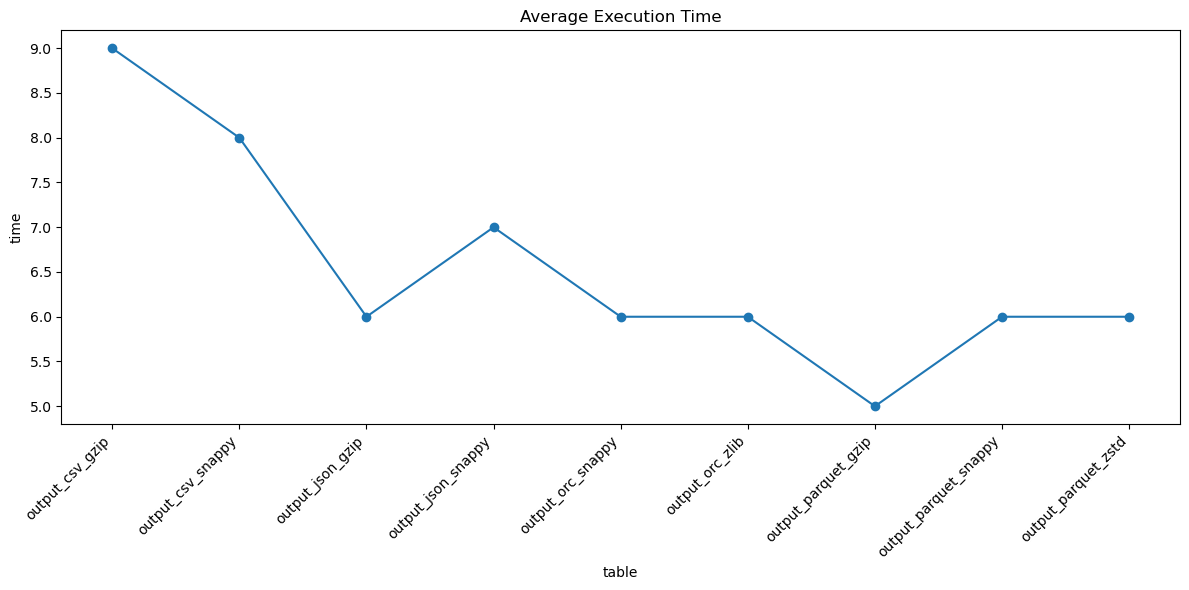

In [18]:
import matplotlib.pyplot as plt
x = results_df['table'].tolist()  # Convert table names to list
y = results_df['avg_duration'].tolist()  # Convert results to list

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('table')
plt.ylabel('time')
plt.title('Average Execution Time')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show() 


In [19]:


import pandas as pd

# Create empty dataframe to store results


def run_query_on_tables(table_names, connection_string):

    df = pd.DataFrame(columns=['query', 'querytxt', 'avg_duration', 'oldest_ts',
                             'latest_ts' , 'table'])
    
    for table_name in table_names:

        remove_cache ="""
        set enable_result_cache_for_session to off
        """
    
        query = f""" 
        set enable_result_cache_for_session to off;
        Select count(*) from (
        SELECT finaldisposition, sentencetime, court , gender, race , count(*)
        FROM dev.team3.{table_name}
        GROUP BY finaldisposition, sentencetime, court , gender, race
                )
        """

        results_query = f"""
        SELECT query,querytxt,
            AVG(DATEDIFF(sec,starttime,endtime)) avg_duration,
            MIN(starttime) as oldest_ts,
            MAX(endtime) as latest_ts ,'{table_name}' as table
            FROM stl_query
            where querytxt like '%count(*)%{table_name}%' 
            GROUP BY query , querytxt
            Having  avg_duration > 0
            Order by oldest_ts desc limit 1
        """

        # Execute query with table name as parameter
        wr.data_api.redshift.read_sql_query(
        sql=remove_cache,
        con=connection_string,
        )

        # Execute query with table name as parameter
        wr.data_api.redshift.read_sql_query(
        sql=query,
        con=connection_string,
        )

        df_temp= wr.data_api.redshift.read_sql_query(
        sql=results_query,
        con=connection_string
        )

        
        df = pd.concat([df, df_temp], ignore_index=True)
    
    return df

    




In [20]:
table_names = ["output_csv_gzip" ,"output_csv_snappy" ,"output_json_gzip" ,"output_json_snappy" ,"output_orc_snappy" ,"output_orc_zlib" ,"output_parquet_gzip" ,"output_parquet_snappy" ,"output_parquet_zstd"] 

results_df_Q1 = run_query_on_tables(table_names, con_redshift)

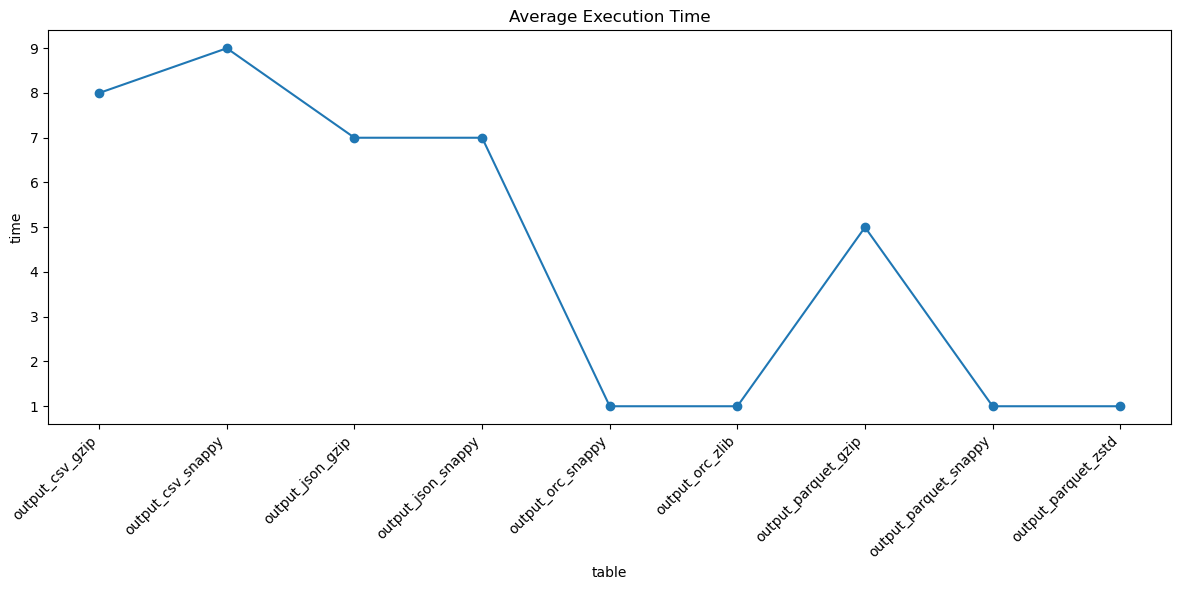

In [21]:
import matplotlib.pyplot as plt
x = results_df_Q1['table'].tolist()  # Convert table names to list
y = results_df_Q1['avg_duration'].tolist()  # Convert results to list

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('table')
plt.ylabel('time')
plt.title('Average Execution Time')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show() 
